In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

In [45]:
# Cargar el dataset
data = pd.read_csv('train.csv',sep=",")

# Convertir la columna 'date' a datetime y establecerla como índice
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Resamplear los datos a nivel mensual, sumando el consumo
data_daily = data.groupby('substation').resample('D').sum()

# Lista de subestaciones únicas
substations = data['substation'].unique()

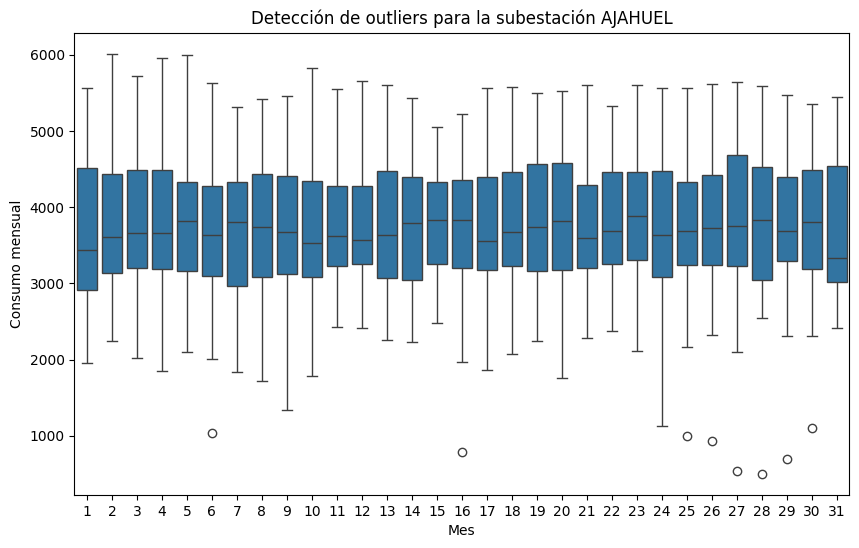

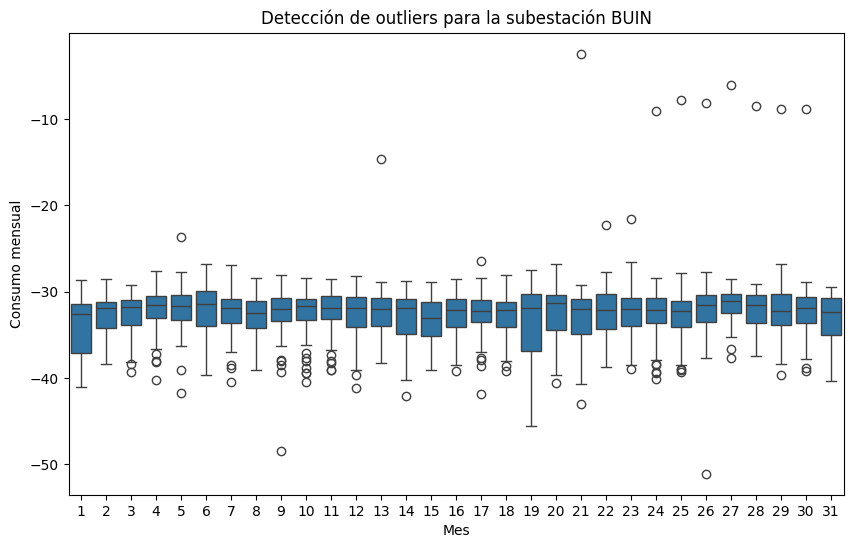

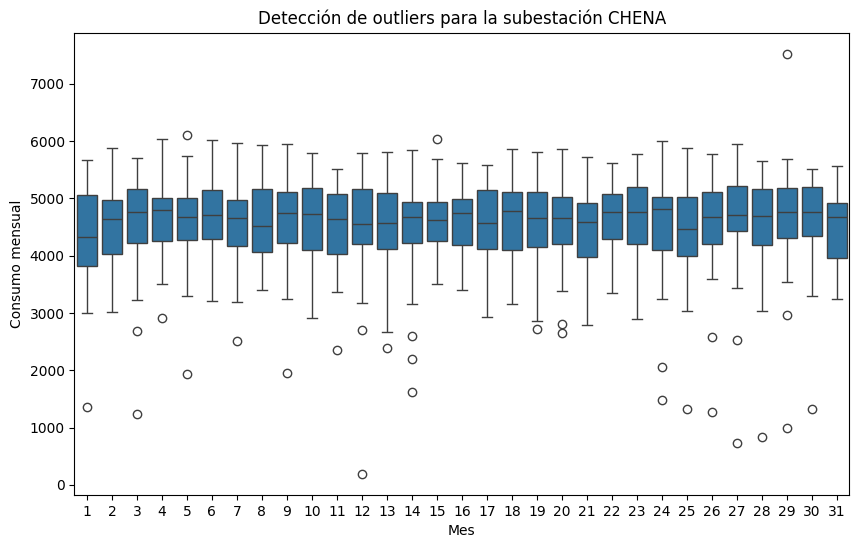

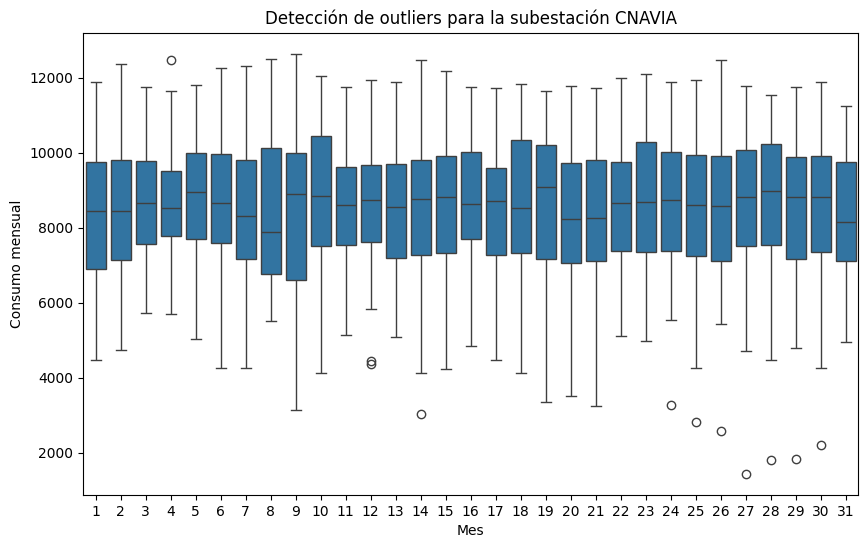

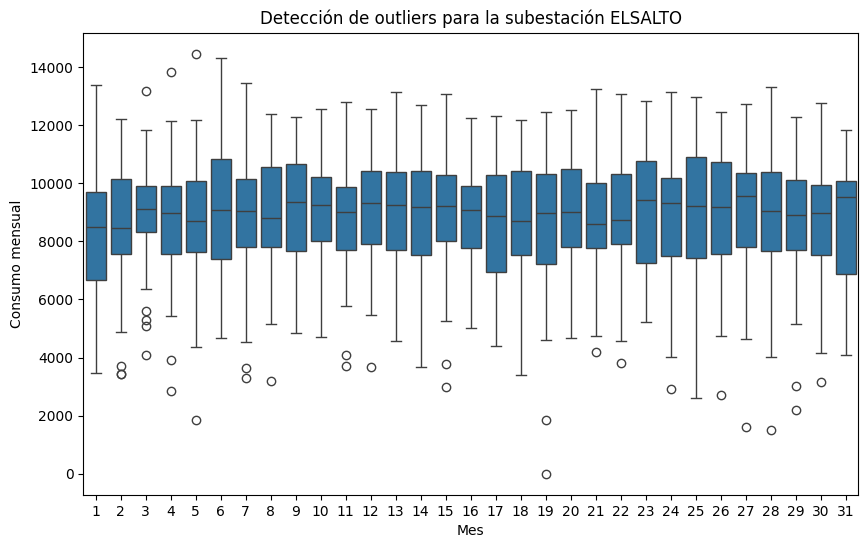

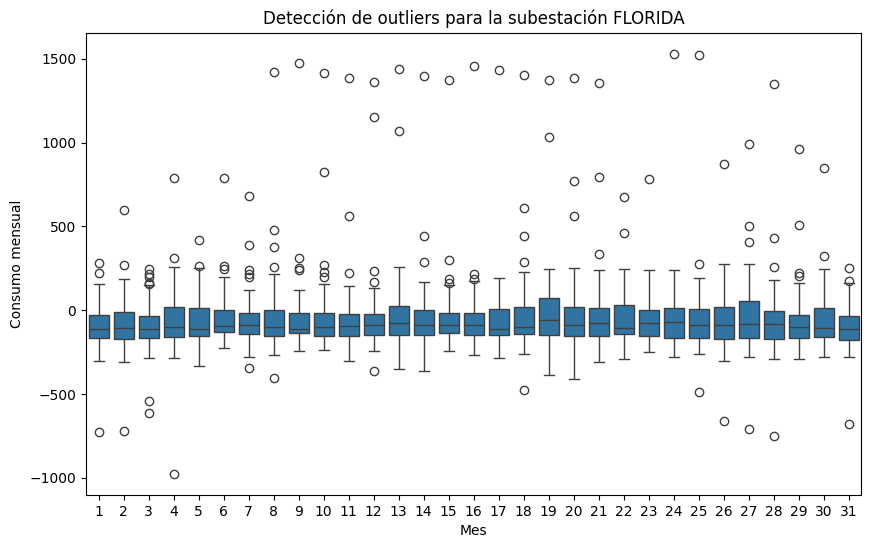

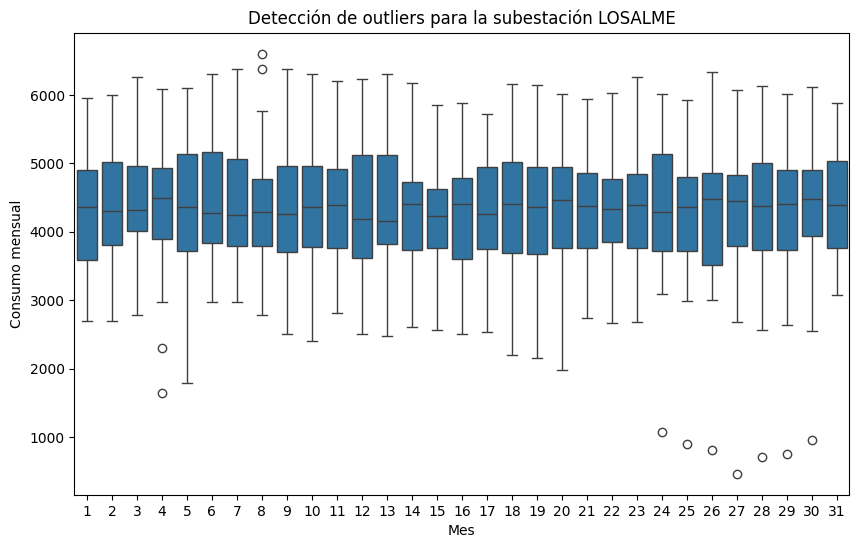

In [46]:
# BUSQUEDA DE OUTLIERS
import seaborn as sns

# Función para detectar outliers en base al IQR por subestación y graficar
def graficar_outliers_por_subestacion(data):
    subestaciones = data.index.get_level_values('substation').unique()

    # Crear un gráfico de caja para cada subestación
    for substation in subestaciones:
        substation_data = data.loc[substation]
        
        # Crear un boxplot para el consumo mensual de cada subestación
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=substation_data.index.day, y=substation_data['consumption'])
        
        # Configurar los títulos y etiquetas
        plt.title(f"Detección de outliers para la subestación {substation}")
        plt.xlabel('Mes')
        plt.ylabel('Consumo mensual')
        
        # Mostrar el gráfico
        plt.show()

# Graficar los outliers para cada subestación
graficar_outliers_por_subestacion(data_daily)


In [47]:
# DESCRIPCION ESTDISTICA DE LOS VALORES
# Agrupar los datos por subestación y aplicar el método describe() para cada subestación
substation_stats = data.groupby('substation')['consumption'].describe()

# Mostrar las estadísticas descriptivas para cada subestación
print(substation_stats)


              count        mean         std         min         25%  \
substation                                                            
AJAHUEL     34913.0  157.707850   53.688217 -159.019095  119.887099   
BUIN        34913.0   -1.361849    0.245542   -3.194611   -1.569758   
CHENA       34913.0  191.423875   48.962242  -74.498545  154.870760   
CNAVIA      34913.0  358.862934  109.495187  -92.670096  280.748739   
ELSALTO     34913.0  370.651085  124.571119    0.000000  280.676014   
FLORIDA     34913.0   -1.833216   11.649272  -77.782766   -6.928774   
LOSALME     34913.0  181.402494   50.377007   -1.026872  144.974119   

                   50%         75%         max  
substation                                      
AJAHUEL     156.714029  194.042396  348.887471  
BUIN         -1.390247   -1.138355    6.623003  
CHENA       193.548373  228.953700  486.400665  
CNAVIA      356.849990  439.677918  752.006309  
ELSALTO     367.540255  463.928697  749.894004  
FLORIDA      -3.9

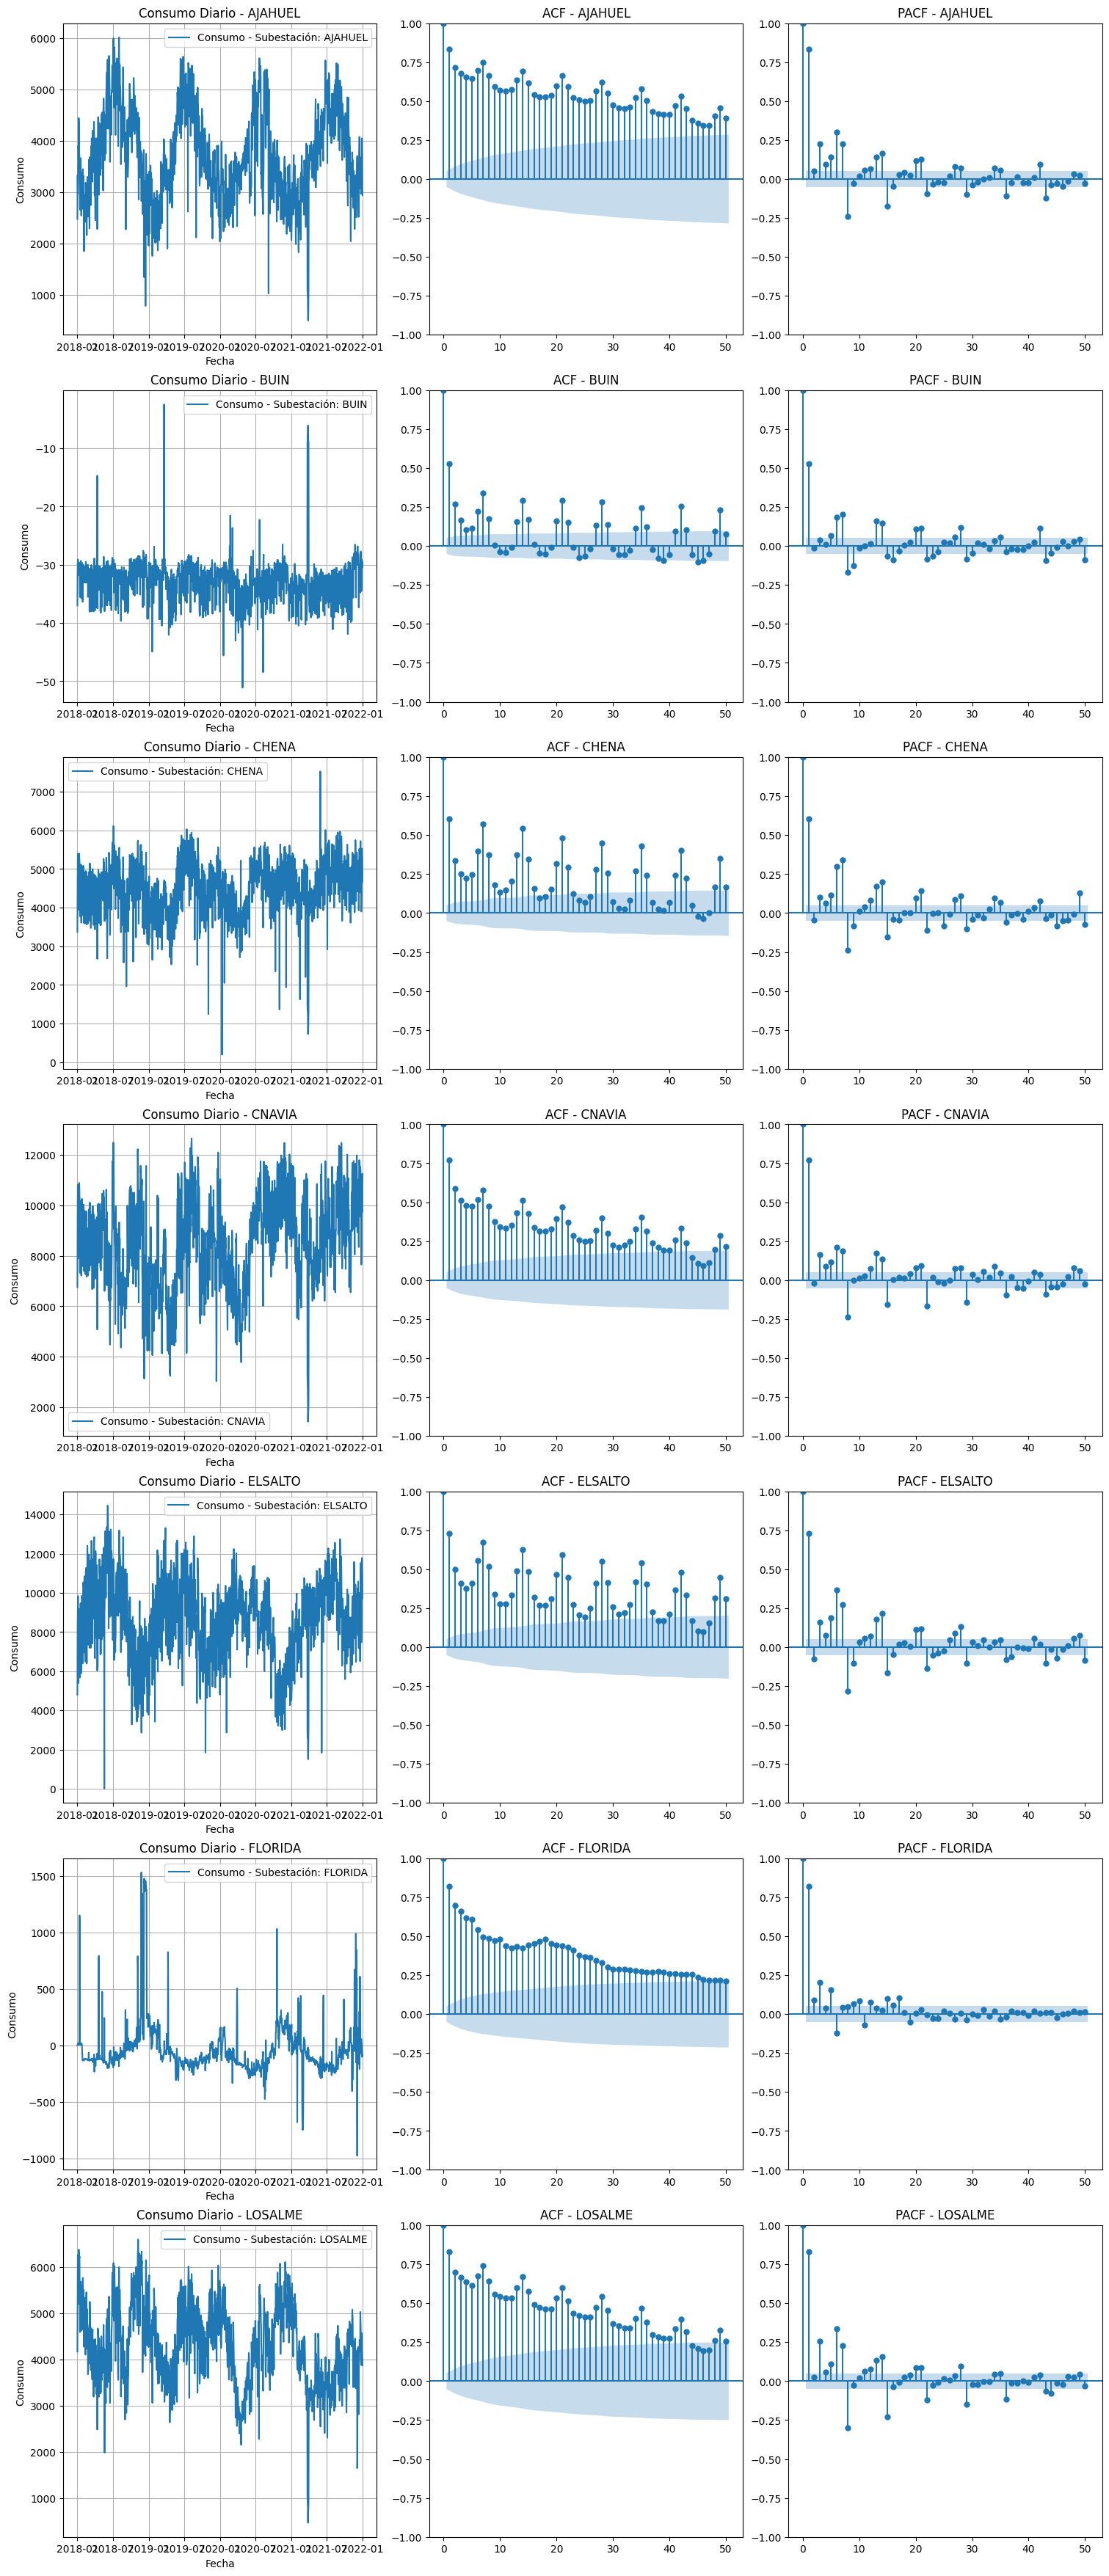

In [66]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

num_lags = 50

# Lista de subestaciones únicas
substations = data['substation'].unique()

# Número de gráficos por fila y por columna
n_cols = 3
n_rows = (len(substations) * 3 + n_cols - 1) // n_cols  # Calcular el número de filas necesarias

# Crear una figura con subgráficas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)

# Aplanar el array de ejes para facilitar la iteración
axes = axes.flatten()

# Contador para la posición actual de ejes
current_axis = 0

# Crear gráficos para cada subestación
for substation in substations:
    # Filtrar los datos para la subestación actual
    substation_data = data_daily.xs(substation, level='substation')['consumption']
    
    # Graficar el consumo mensual
    ax = axes[current_axis]
    ax.plot(substation_data.index, substation_data, label=f'Consumo - Subestación: {substation}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Consumo')
    ax.set_title(f'Consumo Diario - {substation}')
    ax.legend()
    ax.grid(True)
    current_axis += 1
    
    # Graficar la autocorrelación
    ax = axes[current_axis]
    plot_acf(substation_data, lags=num_lags, ax=ax)
    ax.set_title(f'ACF - {substation}')
    current_axis += 1
    
    # Graficar la autocorrelación parcial
    ax = axes[current_axis]
    plot_pacf(substation_data, lags=num_lags, ax=ax)
    ax.set_title(f'PACF - {substation}')
    current_axis += 1

# Eliminar cualquier eje no utilizado si hay menos gráficos que subgráficas
for i in range(current_axis, len(axes)):
    fig.delaxes(axes[i])

# Mostrar los gráficos
plt.show()

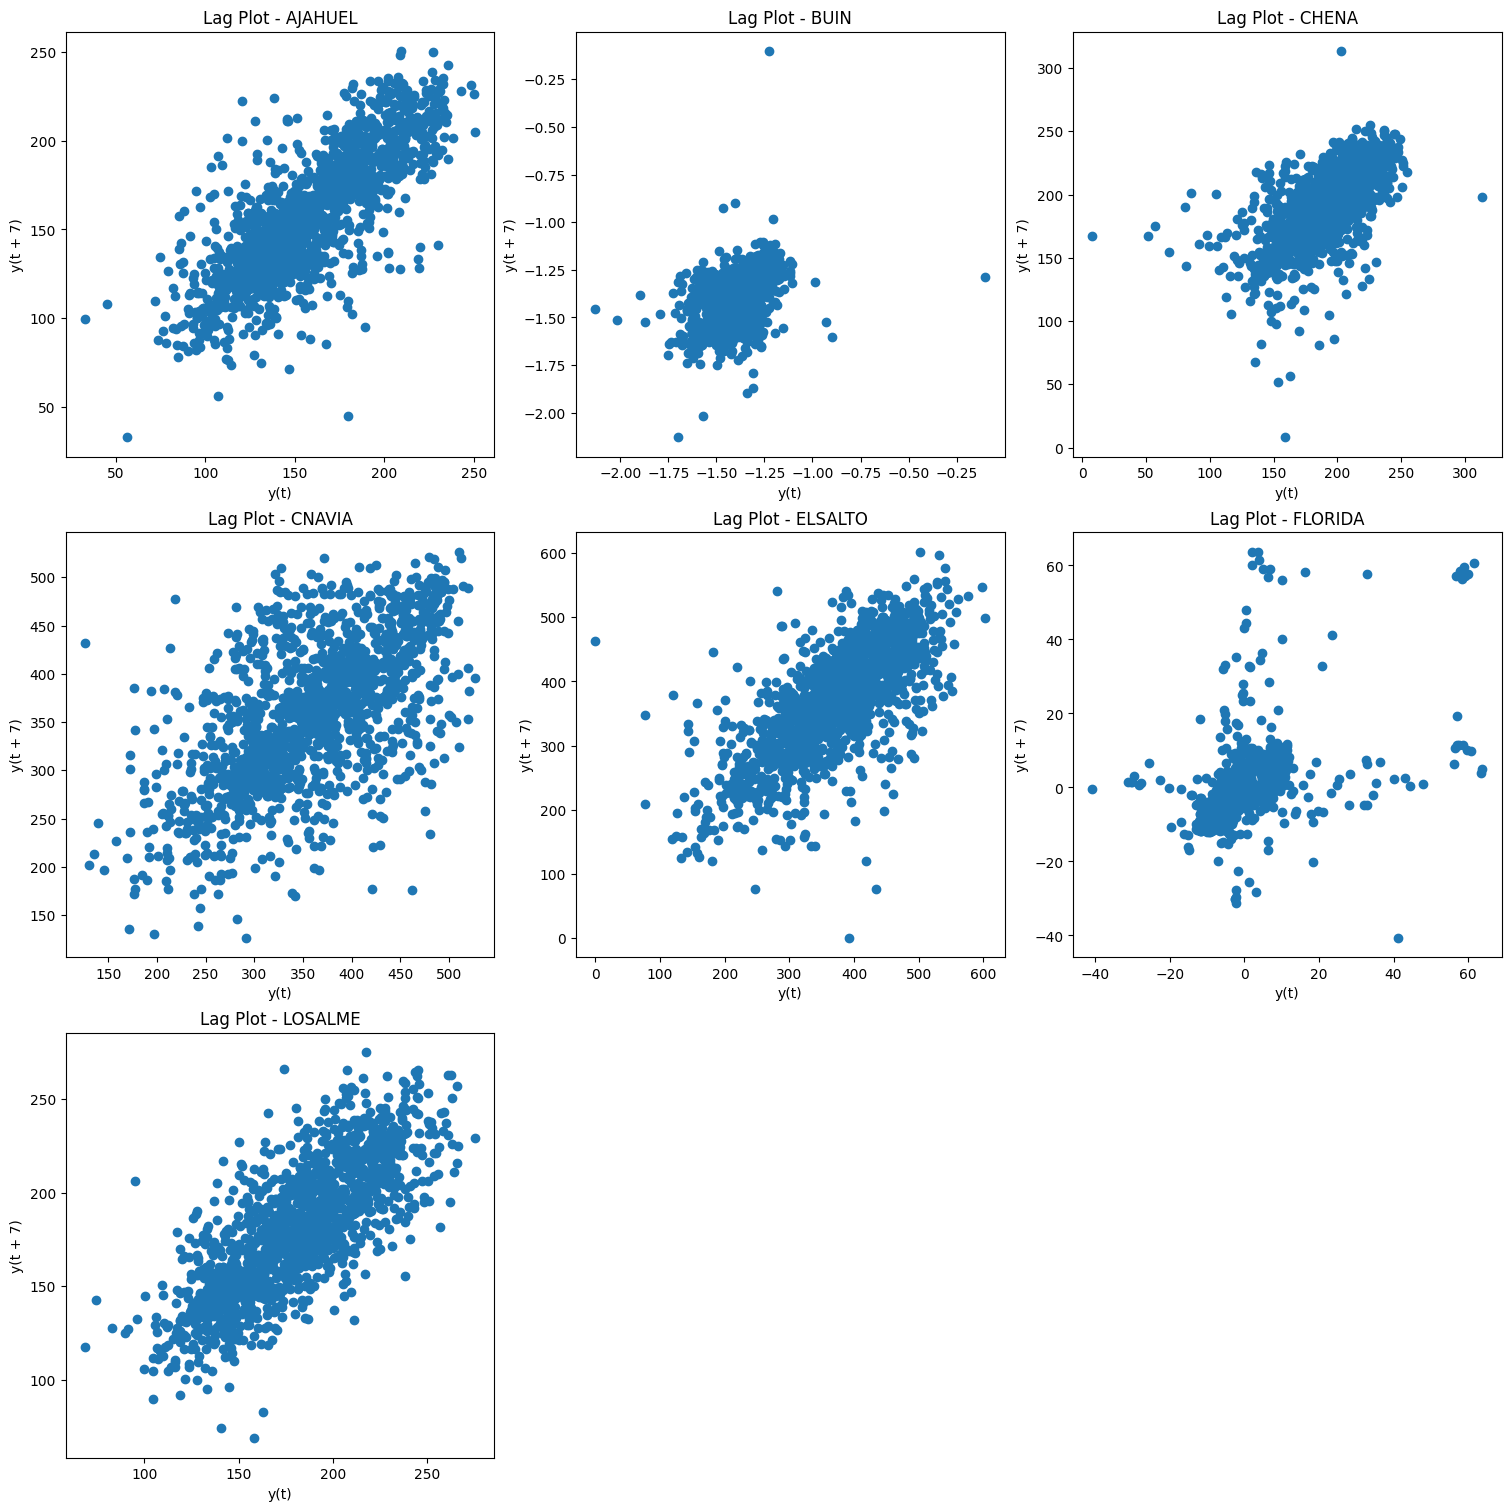

In [67]:
from pandas.plotting import lag_plot

num_lags = 7

# Agrupar el dataset por día (resampling) y obtener el consumo diario
daily_data = data.groupby([data.index.date, 'substation']).mean()

# Lista de subestaciones
substations = data['substation'].unique()

# Configuración de los gráficos: Número de columnas y filas necesarias
n_cols = 3
n_rows = (len(substations) + n_cols - 1) // n_cols  # Calcular el número de filas necesarias

# Crear figura con subgráficas
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)
axes = axes.flatten()

# Crear lag plots para cada subestación
for i, substation in enumerate(substations):
    # Filtrar datos para la subestación actual (uso de xs para acceder al MultiIndex)
    substation_data = daily_data.xs(substation, level='substation')['consumption'].dropna()
    
    # Graficar el lag plot
    lag_plot(substation_data, num_lags, ax=axes[i])
    axes[i].set_title(f'Lag Plot - {substation}')

# Eliminar cualquier eje no utilizado si hay menos subestaciones que subgráficas
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Mostrar los gráficos
plt.show()



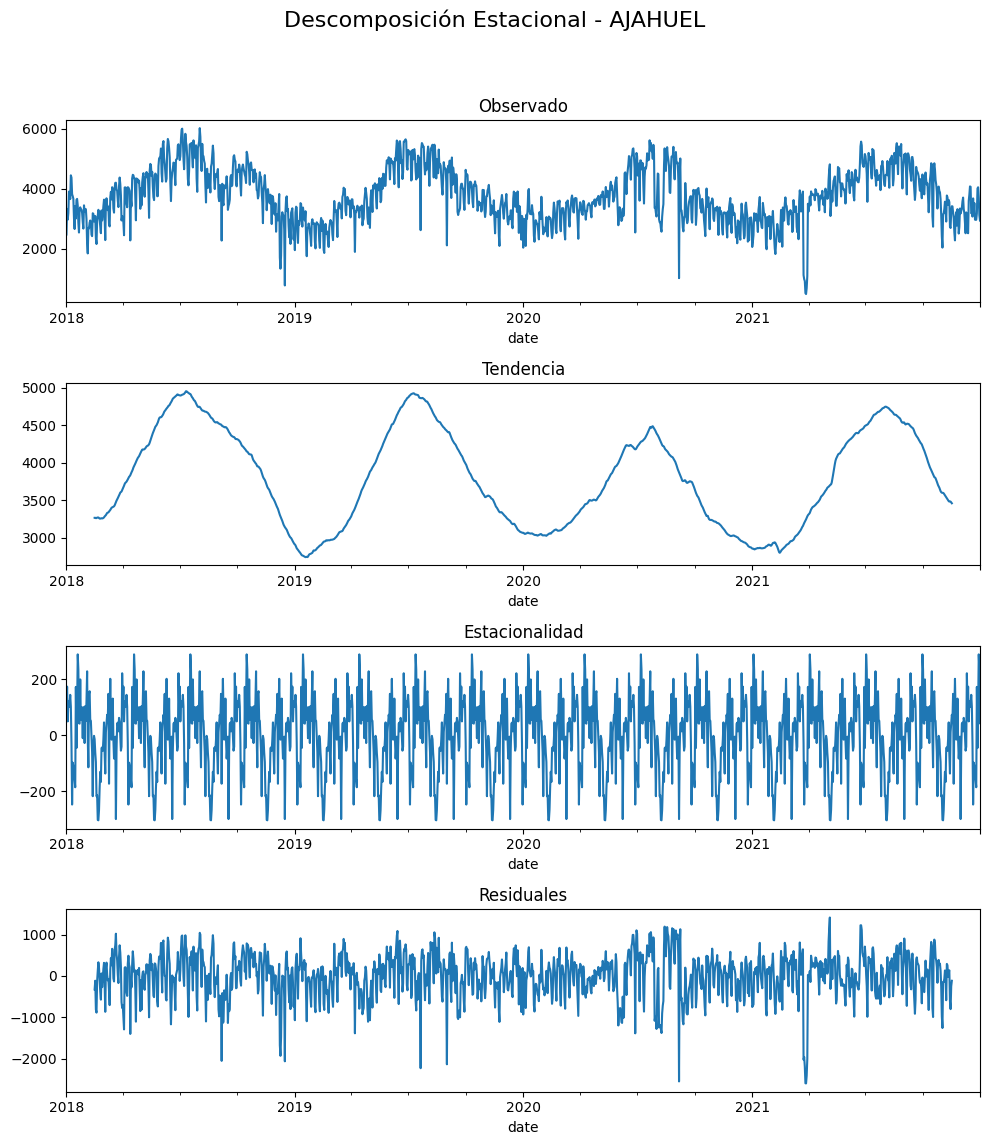

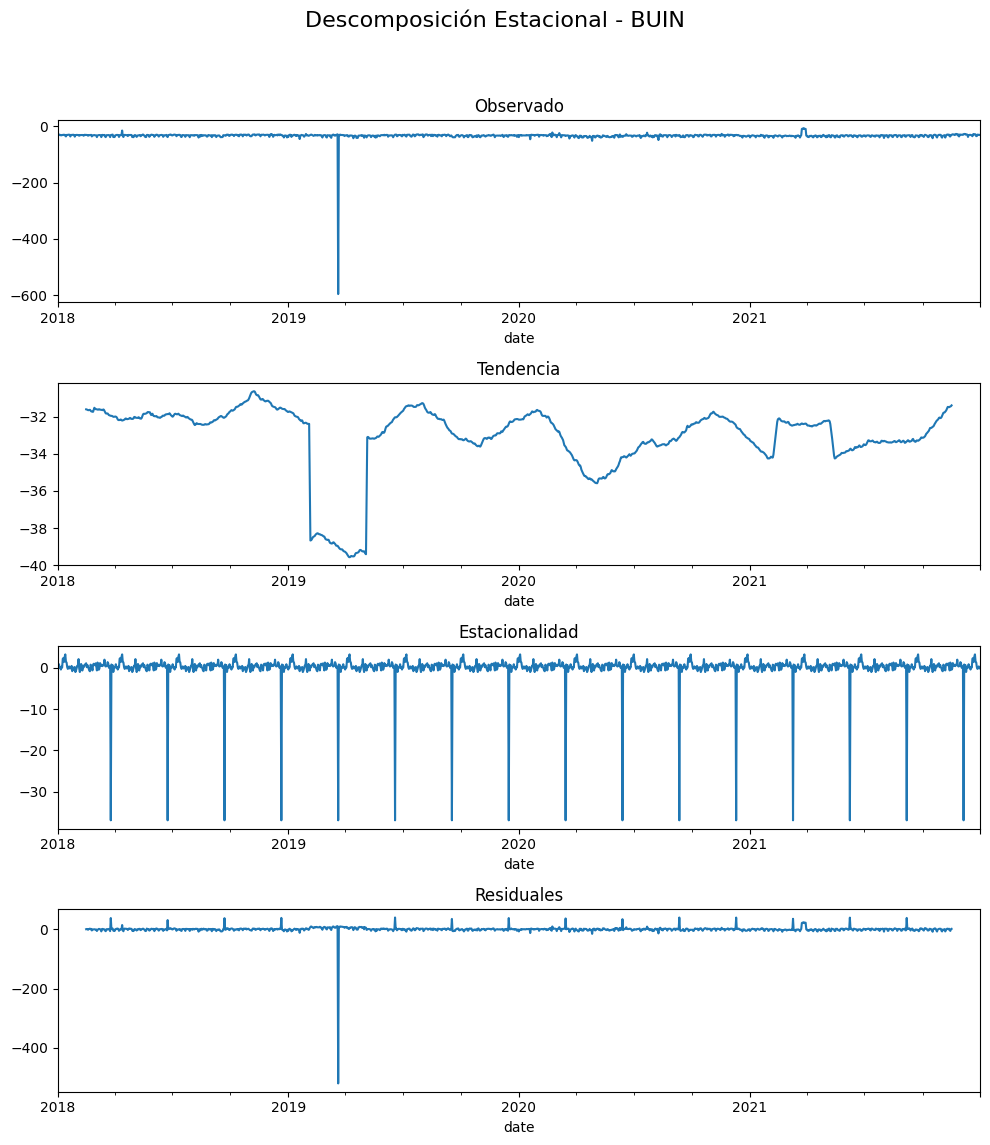

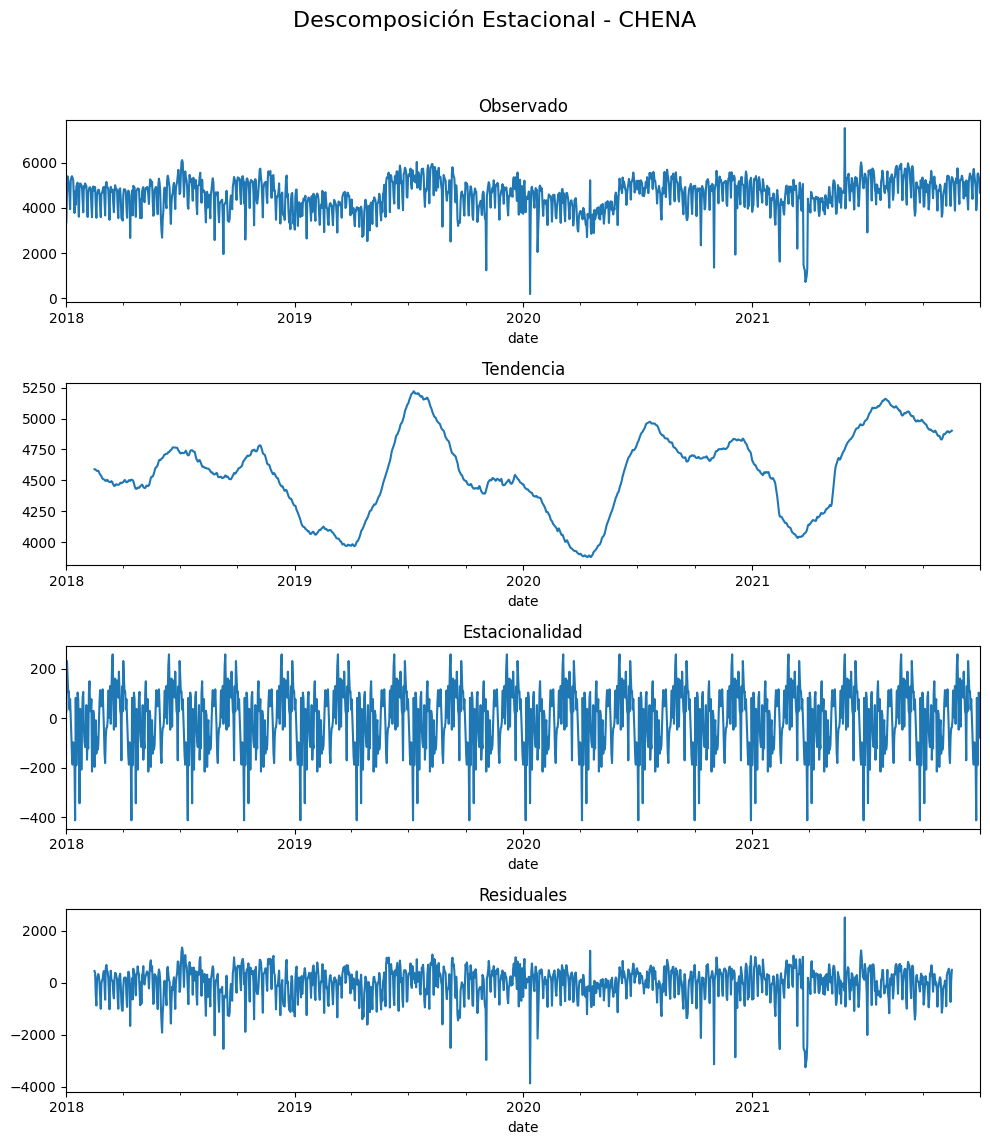

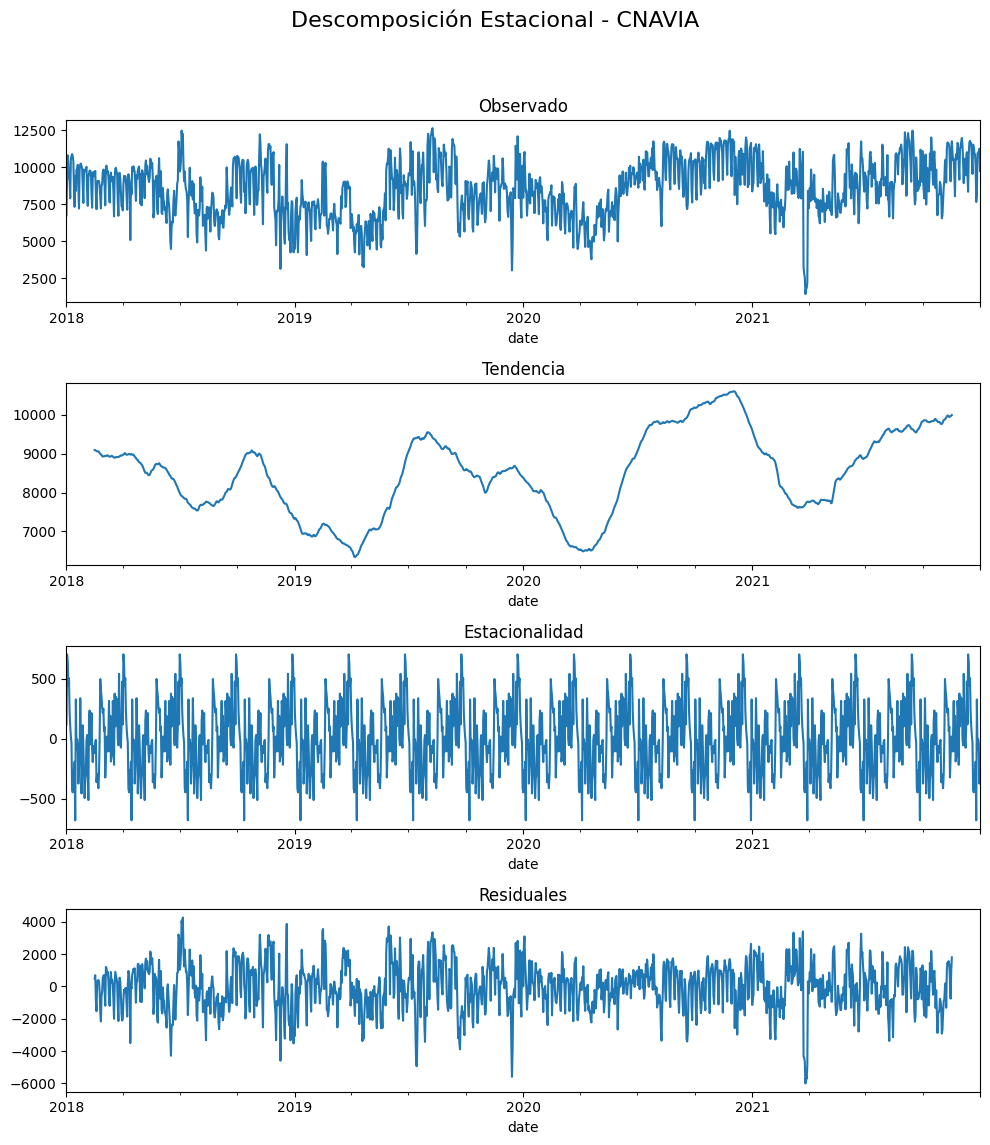

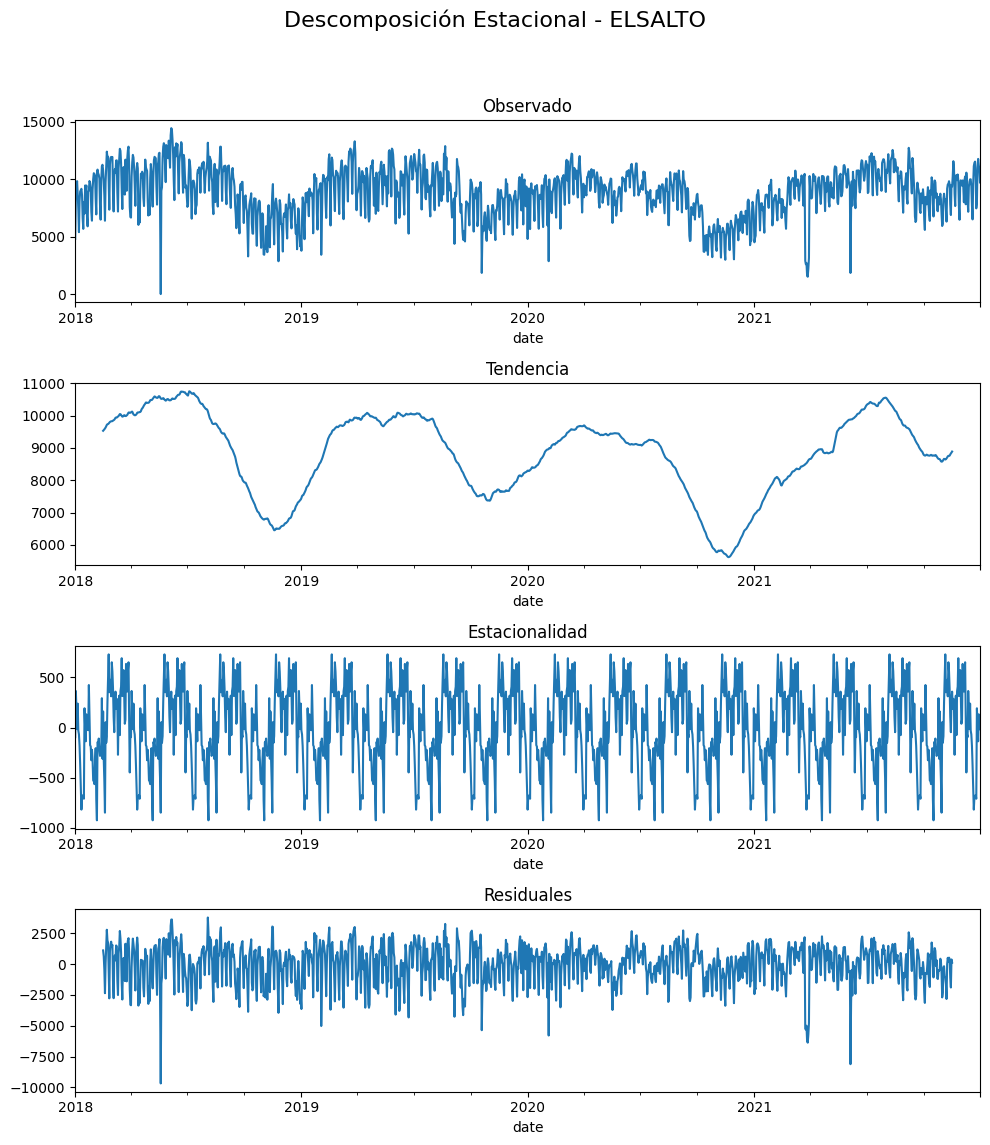

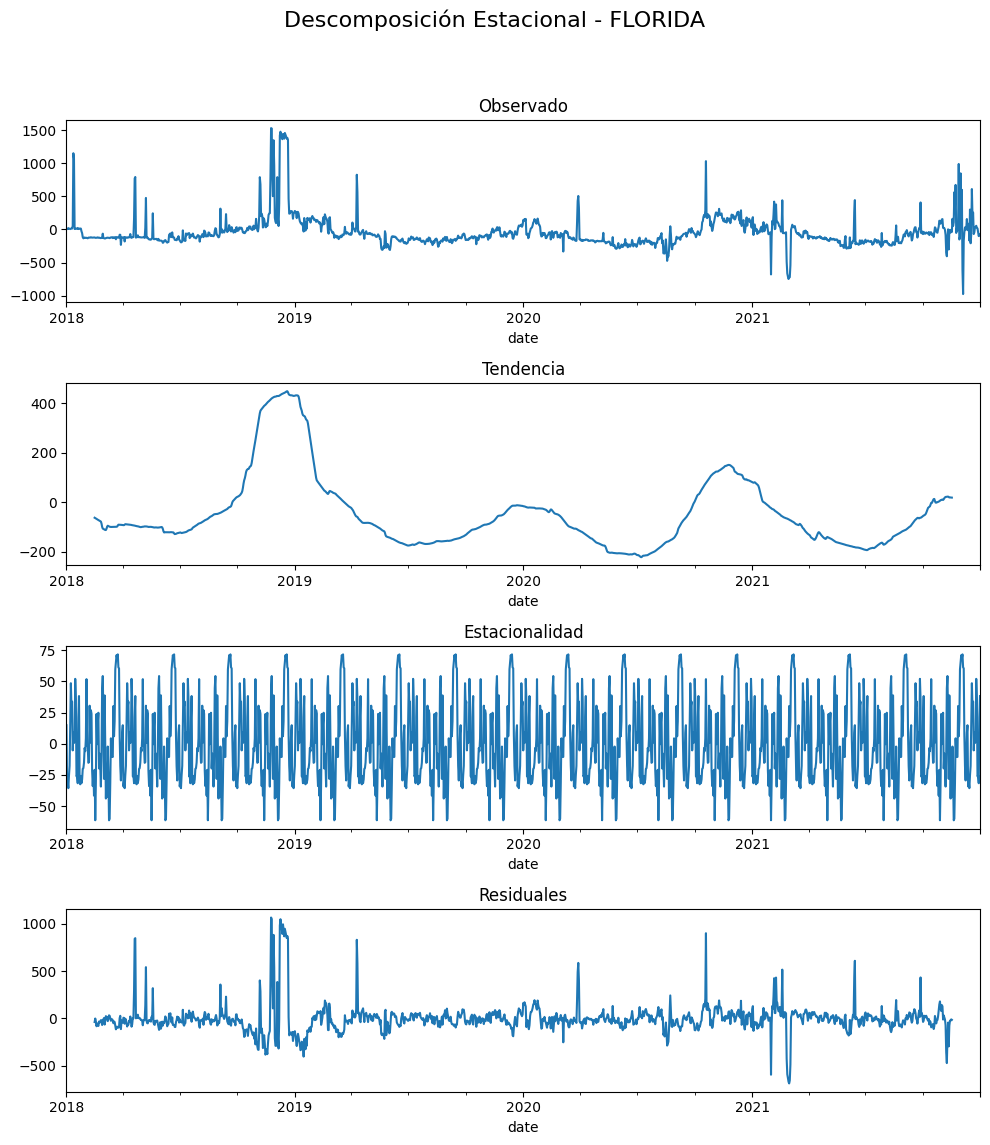

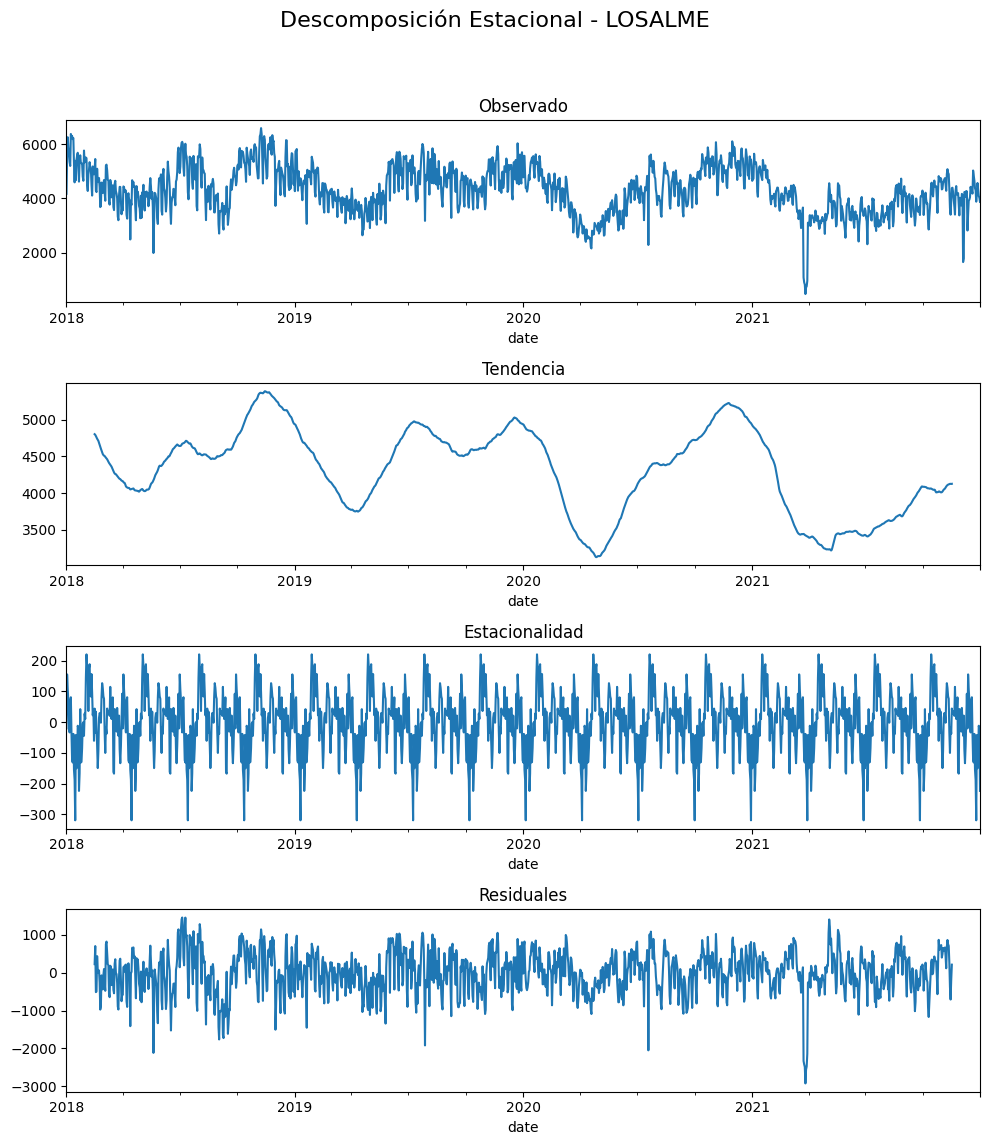

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Parámetro para el período de la descomposición estacional
period = 90

# Graficar la descomposición estacional para cada subestación
for substation in substations:
    # Filtrar los datos para la subestación actual y asegurar que solo se toman los datos mensuales
    data_substation = data_daily.xs(substation, level='substation')['consumption']
    
    # Aplicar la descomposición estacional
    resultado = seasonal_decompose(data_substation, model='additive', period=period)
    
    # Crear una figura para cada subestación
    fig, axes = plt.subplots(4, 1, figsize=(10, 12))
    fig.suptitle(f'Descomposición Estacional - {substation}', fontsize=16)
    
    # Graficar los componentes de la descomposición
    resultado.observed.plot(ax=axes[0], title='Observado')
    resultado.trend.plot(ax=axes[1], title='Tendencia')
    resultado.seasonal.plot(ax=axes[2], title='Estacionalidad')
    resultado.resid.plot(ax=axes[3], title='Residuales')
    
    # Ajustar el diseño para que no se solapen los gráficos
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
